Memuat Data

In [1]:
import pandas as pd

# Memuat dataset
#file_path = 'path/to/your/datasetai2020.csv'
from google.colab import files
uploaded = files.upload()
datasetai2020_csv = next(iter(uploaded))
dataset = pd.read_csv(datasetai2020_csv)

# Menampilkan beberapa baris pertama dari dataset
print(dataset.head())


Saving datasetai2020.csv to datasetai2020.csv
   UDI Product ID Type  Air temperature [K]  Process temperature [K]  \
0    1     M14860    M                298.1                    308.6   
1    2     L47181    L                298.2                    308.7   
2    3     L47182    L                298.1                    308.5   
3    4     L47183    L                298.2                    308.6   
4    5     L47184    L                298.2                    308.7   

   Rotational speed [rpm]  Torque [Nm]  Tool wear [min]  Machine failure  TWF  \
0                    1551         42.8                0                0    0   
1                    1408         46.3                3                0    0   
2                    1498         49.4                5                0    0   
3                    1433         39.5                7                0    0   
4                    1408         40.0                9                0    0   

   HDF  PWF  OSF  RNF  
0    0    

Prapemrosesan Data

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Menangani nilai yang hilang
# Select only numeric columns for imputation
numeric_columns = dataset.select_dtypes(include=['number']).columns
imputer = SimpleImputer(strategy='mean')
dataset[numeric_columns] = imputer.fit_transform(dataset[numeric_columns])

# Encoding untuk kolom kategorikal
encoder = OneHotEncoder()
encoded_features = pd.DataFrame(encoder.fit_transform(dataset[['Type']]).toarray(), columns=encoder.get_feature_names_out(['Type']))
dataset_encoded = pd.concat([dataset.drop('Type', axis=1), encoded_features], axis=1)

# Memisahkan fitur dan label
X = dataset_encoded.drop(['Machine failure', 'Product ID'], axis=1)
y = dataset_encoded['Machine failure']

# Membagi data menjadi data latih dan data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menstandarkan fitur
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Melatih Model Pembelajaran Mesin

In [4]:
import lightgbm as lgb
from sklearn.metrics import classification_report, confusion_matrix

# Melatih model LightGBM
model = lgb.LGBMClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Memprediksi data uji
y_pred = model.predict(X_test)

# Menampilkan hasil prediksi
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))


[LightGBM] [Info] Number of positive: 278, number of negative: 7722
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000987 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1200
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034750 -> initscore=-3.324208
[LightGBM] [Info] Start training from score -3.324208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[[1939    0]
 [   2   59]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1939
         1.0       1.00      0.97      0.98        61

    accuracy                           1.00      2000
   macro avg       1.00      0.98      0.99      2000
weighted avg       1.00      1.00      1.00      2000



Mengevaluasi Model

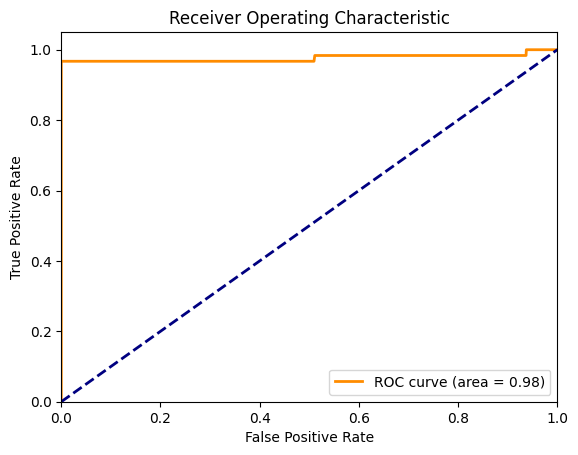

In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Menghitung probabilitas prediksi
y_prob = model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Menampilkan kurva ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()
